### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/fuzzy">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Mount with google drive.
from google.colab import drive
drive.mount('/content/dirve')

# Import other libraries required.
# All *.py will be stored under the following 
# location i.e. '/content/supervised_binning'.
!git clone 'http://github.com/Nak007/fuzzy.git'

# Change current directory to where *.py is stored.
%cd '/content/fuzzy'

# Install 'scikit-fuzzy'
!pip install scikit-fuzzy

## Example

In [23]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.cluster import (KMeans, DBSCAN)
from scipy.spatial.distance import cdist

# import * from fuzzy_logic.py.
from fuzzy_logic import *

In [2]:
def fuzzy_2D_plot(X, C, Jm, n=None):
    
    plt.scatter(X[:,0], X[:,1], c='grey', alpha=0.4)
    kw = dict(lw=1, ls='--', marker='s', ms=5)
    for c in C:
        plt.plot(c[:,0], c[:,1], label=f'Cluster {n+1}', **kw)
    plt.title('Number of iterations : {:,}\n' 
              'Error : {:,.4g} ⟶ {:,.4g}'
              .format(n, Jm[0], Jm[-1]))

def cluster_2D_plot(X, y, C):
    
    for n in np.unique(y):
        plt.scatter(X[y==n,0], X[y==n,1], alpha=0.4)
    plt.scatter(C[:,0], C[:,1], s=500, fc='white', 
                ls='-', ec='k', alpha=1, lw=2)
    kw = dict(va='center', ha='center', c='k', fontsize=12)
    for n,xy in enumerate(C): plt.annotate('{}'.format(n+1),xy, **kw)
    plt.title('Cluster-centers')

def comupute_centers(X, init, m):
    
    '''Compute cluster centers'''
    um = init**m
    return (um.T.dot(X).T/um.sum(axis=0)).T
    
def kmean_path(n_clusters, init, tol=1e-4):
    
    # Initialize loop parameters.
    n, ssw = 0, np.inf
    ssw_, centers = [], [init.ravel()]
    
    while n < 500:
        n += 1
        model = KMeans(n_clusters=n_clusters, 
                       init=init, n_init=1, max_iter=n)
        model.fit(X)
        ssw_.append(model.inertia_)
        centers.append(model.cluster_centers_)
        
        if np.linalg.norm(ssw-ssw_[-1])<tol: break
        ssw = ssw_[-1].copy()
    
    # Transform `centers`, where each index stores
    # cluster center from every iteration.
    centers = np.array([n.ravel() for n in centers])
    indices = int(centers.shape[1]/X.shape[1])
    centers = np.hsplit(centers, indices)
    
    return centers, ssw_, n

[**Distance function**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)

**<font color='blue' size=4>Function : fuzz.cluster.cmeans</font>**
- [fuzzy c-means](https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html)
- [wikipedia](https://en.wikipedia.org/wiki/Fuzzy_clustering)

---
<font size=4>**Fuzzy c-Means Algorithm**</font>

To describe a method to determine the fuzzy $c$-partition matrix $U$ for grouping a collection of $n$ data sets into $c$ classes, we define an objective function $J_{m}$ for a fuzzy $c$-partition:

> $J_{m}(U,v) = \sum_{k=1}^{n}\sum_{i=1}^{c}(\mu_{ik})^{m'}(d_{ik})^2$

where

> $d_{ik} = d(x_{k} - v_{i}) = [\sum_{j=1}^{m}(x_{kj}-v_{ij})^2]^\frac{1}{2}$

and where $\mu_{ik}$ is the membership of the $k$th data point in the $i$th class. $j$ is a variable on the feature space, that is, $j$ = 1, 2, . . .,$m$. The distance measure, $d_{ik}$ is a Euclidean distance between the $i$th cluster center and the $k$th data set. A new parameter is introduced called a **weighting parameter**, $m$ (**Bezdek, 1981**). This value has a range $m = [1,\inf)$ This parameter controls the amount of fuzziness in the classification process. Also, $v_{i}$ is the $i$th cluster center, which is described by $m$ features and can be arranged in vector form as before, $v_{i} = \{v_{i1}, v_{i2}, . . . , v_{im}\}$.

Each of the cluster coordinates for each class can be calculated in a manner similar to the calculation in the crisp case:

> $v_{ij} = \left(\frac{\sum_{k=1}^{n}\mu_{ik}^{m'}\cdot x_{ki}}{\sum_{k=1}^{n}\mu_{ik}^{m'}}\right)$

---
An effective algorithm for fuzzy classification, called iterative optimization, was proposed by **Bezdek (1981)**. The steps in this algorithm are as follows:

1. Fix $c$ $(2 ≤ c < n)$ and select a value for parameter $m$. Initialize the partition matrix, $U^{(0)}$. Each step in this algorithm will be labeled $r$, where $r$ = 0, 1, 2, . . .
2. Calculate the $c$ centers $\{v^{(r)}_{i}\}$ for each step.
3. Update the partition matrix for the rth step, $U^{(r)}$, as follows:

> $\mu_{ik}^{(r+1)}=\left[\sum_{j=1}^{c}\left(\frac{d_{ik}^{(r)}}{d_{jk}^{(r)}}\right)^{2/(m'-1)}\right]^{-1}$ , for $I_{k} = \emptyset$ , where $\sum_{i\in I_{k}}\mu_{ik}^{(r+1)}=1$

4. If $\Vert U^{(r+1)}-U^{(r)}\Vert \leq \epsilon_{L}$, stop; otherwise set $r = r + 1$ and return to step 2.

see `fuzz.cluster.cmeans.__doc__` for more information.

In [3]:
n_samples =500
n_clusters = 4
random_state = 204 #170
cluster_std = np.random.rand(n_clusters) + 1
aniso = False

Generate isotropic Gaussian blobs for clustering (mock-up data).

In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=2, 
                  random_state=random_state, cluster_std=cluster_std)

Change `X` into anisotropically distributed blobs (run to see different outcome in clustering).

In [5]:
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
if aniso: X = np.dot(X, transformation)

Initialize parameters for `fuzzy c-means`.
- `weight` : Weighting parameter.
- `max_iter` : Maximum number of iterations of `fuzzy_cmeans` algorithm for a single run.

In [6]:
weight = 2
max_iter = 100

Create initial **fuzzy c-partition** by randomly assign value $\{\mu \in R | a < x < b\}$ for each instance, where $\sum_{n=1}^{k}\mu_{n} = 1$, and $k$ is a number of clusters.

In [7]:
init = np.random.rand(500, n_clusters).astype(np.float64)
init = np.fmax(init, np.finfo(np.float64).eps)
init = init/init.sum(axis=1).reshape(-1,1)
np.round(init,2)

array([[0.26, 0.24, 0.08, 0.41],
       [0.1 , 0.19, 0.56, 0.15],
       [0.34, 0.2 , 0.09, 0.37],
       ...,
       [0.3 , 0.21, 0.2 , 0.29],
       [0.14, 0.57, 0.1 , 0.2 ],
       [0.26, 0.22, 0.12, 0.4 ]])

Fit `fuzz.cluster.cmeans` with predefined paramerters.

In [8]:
kwargs = dict(c=n_clusters, m=weight, error=0.005, maxiter=max_iter, init=init.T)
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, **kwargs)

Visualize result in 2D plot.

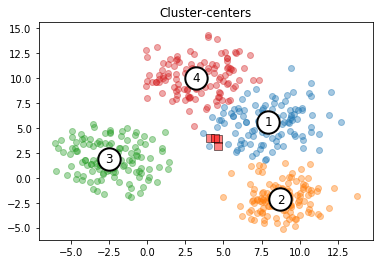

In [9]:
# Plot results
#cluster_2D_plot(X, y, cntr)
cluster_2D_plot(X, np.argmax(u.T,axis=1), cntr)

# Plot initial cluster centers.
clusters0 = comupute_centers(X, init, weight)
k = dict(marker='s', lw=1, s=50, alpha=0.5, c='r', ec='k')
plt.scatter(clusters0[:,0], clusters0[:,1], **k)
plt.show()

Partitioned matrix from **`fuzz.cluster.cmeans`**

In [10]:
np.round(u,3).T[:10,:]

array([[0.042, 0.036, 0.861, 0.061],
       [0.04 , 0.029, 0.866, 0.065],
       [0.02 , 0.006, 0.011, 0.963],
       [0.616, 0.126, 0.062, 0.197],
       [0.675, 0.196, 0.053, 0.077],
       [0.05 , 0.909, 0.022, 0.019],
       [0.008, 0.985, 0.004, 0.003],
       [0.034, 0.027, 0.899, 0.04 ],
       [0.032, 0.026, 0.894, 0.048],
       [0.041, 0.01 , 0.023, 0.925]])

**<font color='blue' size=4>Class : fuzzy_cmeans</font>**
---
Available functions:
- `self.fit_predict`
- `self.predict`
- `self.transform`

See `fuzzy_cmeans.__doc__` for more information.

Initialize **`fuzzy_cmeans`** class.

In [11]:
model = fuzzy_cmeans(init=init, m=weight)

Compute `cluster centers`, `partitioned matrix`, and other attributes for each sample.

In [12]:
model.fit_predict(X)

/Users/administrator/Desktop/Python Projects/++ cluster ++/fuzzy/fuzzy_logic.py:280: UserWarning: Explicit initial fuzzy c-partitioned matrix passed: performing only one init in fuzzy_cmeans instead of n_init=10.
  warn(f'Explicit initial fuzzy c-partitioned matrix passed: '


Partitioned matrix as an `attribute` from **`fuzzy_cmeans`**

In [13]:
np.round(model.partition[:10,:], 3)

array([[0.042, 0.036, 0.861, 0.061],
       [0.04 , 0.029, 0.866, 0.065],
       [0.02 , 0.006, 0.011, 0.963],
       [0.616, 0.126, 0.062, 0.197],
       [0.675, 0.195, 0.053, 0.077],
       [0.05 , 0.909, 0.022, 0.019],
       [0.008, 0.985, 0.004, 0.003],
       [0.034, 0.027, 0.899, 0.04 ],
       [0.032, 0.026, 0.894, 0.048],
       [0.041, 0.01 , 0.023, 0.925]])

Predict the closest cluster each sample in X belongs to.

In [14]:
#U1, labels = model.fit_predict(X).predict(X)
U1, labels = model.predict(X)

Compute clustering and transform X to cluster-distance space ("Euclidean").

In [15]:
# dist = model.fit_predict(X).transform(X)
model.transform(X)[:10]

array([3.06037974, 2.61378883, 1.09714038, 5.08696195, 2.79623601,
       2.20769731, 0.77239416, 1.81433536, 2.44971212, 1.35700287])

Visualize paths of cluster centers that move across feature space.

Inertia: 2,761.72


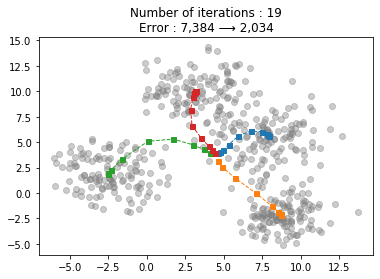

In [16]:
fuzzy_2D_plot(X, model.iter_centers_, model.jm, n=model.n_iter)
print('Inertia: {:,.2f}'.format(model.inertia_))

`fuzzy_cmeans` without initial fuzzy c-partition matrix.

Inertia: 2,761.72


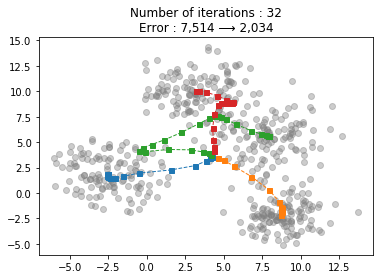

In [17]:
wo_init = fuzzy_cmeans(n_clusters=n_clusters, m=weight)
wo_init.fit_predict(X)
fuzzy_2D_plot(X, wo_init.iter_centers_, wo_init.jm, n=wo_init.n_iter)
print('Inertia: {:,.2f}'.format(model.inertia_))

**<font color='blue' size=4>Class : sklearn.cluster.KMeans</font>**
- [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- [brilliant](https://brilliant.org/wiki/k-means-clustering/)
- [geeksforgeeks](https://www.geeksforgeeks.org/k-means-clustering-introduction/?ref=leftbar-rightbar)

---
<font size=4>**K-Means Algorithm**</font>

The objective function for the K-means clustering algorithm is the squared error function:

> $J = \sum_{i=1}^{k}\sum_{j=1}^{n}\|x_{i}-v_{j}\|^{2}$, where $ x_{i} \in v_{j}$

where $\|x_{i}-v_{j}\|$ is the Eucledian distance between a point, $x_{i}$, and a centroid, $v_{j}$, iterated over all points in the cluster, for all n clusters. $J$ is also referred to `inertia`.

---
The steps in this algorithm are as follows:
1. `k` random points of the data set are chosen to be centroids.
2. Distances between every data point and the `k` centroids are calculated and stored.
3. Based on distance calculates, each point is assigned to the nearest cluster.
4. New cluster centroid positions are updated.
5. If the centroid locations changed, the process repeats from step 2, until the calculated new center stays the same, which signals that the clusters' members and centroids are now set.

In [18]:
kmeans = KMeans(n_clusters=n_clusters, init=clusters0, n_init=1, max_iter=300)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True,
       init=array([[4.67066977, 3.89135583],
       [4.66109159, 3.13648608],
       [4.145161  , 3.98670595],
       [4.42464348, 3.95401373]]),
       max_iter=300, n_clusters=4, n_init=1, n_jobs=None,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

Visualize result in 2D plot.

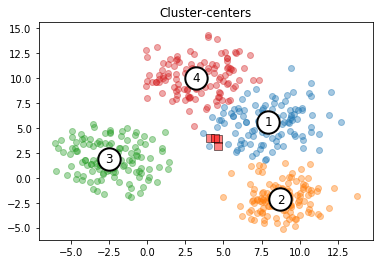

In [19]:
# Plot results
#cluster_2D_plot(X, y, kmeans.cluster_centers_)
cluster_2D_plot(X, kmeans.labels_, cntr)

# Plot initial cluster centers.
k = dict(marker='s', lw=1, s=50, alpha=0.5, c='r', ec='k')
plt.scatter(clusters0[:,0], clusters0[:,1], **k)
plt.show()

Visualize paths of cluster centers that move across feature space.

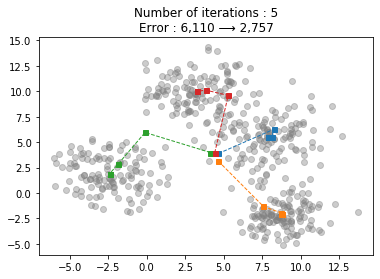

In [20]:
centers, ssw, n = kmean_path(n_clusters, clusters0)
fuzzy_2D_plot(X, centers, ssw, n=n)

**<font color='blue' size=4>Class : sklearn.cluster.DBSCAN</font>** 
- [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
- [wikipedia](https://en.wikipedia.org/wiki/DBSCAN)
- [geeksforgeeks](https://www.geeksforgeeks.org/ml-dbscan-reachability-and-connectivity/)

---
**Parameters**
- **$Eps$**: distance, which can be any metric.
- **$MinPts$**: Minimum number of neighbors (data points) within eps radius.
- **Core Point**: A point is a core point if it has more than MinPts points within eps.
- **Border Point**: A point which has fewer than $MinPts$ within $Eps$ but it is in the neighborhood of a core point.
- **Noise** or **outlier**: A point which is not a core point or border point.

---
**Definition 1**: (Eps-neighborhood of a point) The Eps-neighborhood of a point $p$, denoted by $N_{Eps}(p)$, is defined

> $N_{Eps}(p) = \{q \in D|dist(p,q) \leq Eps\}$

There are two kinds of points in a cluster, points inside of the cluster (`core points`) and points on the border of the cluster (`border points`).

---
**Definition 2**: (directly density-reachable) A point $p$ is directly density-reachable from a point $q$ wrt. $Eps$, $MinPts$ if

> 1. $p \in N_{Eps}(q)$
> 2. $\|N_{Eps}(q)\| \geq MinPts$ (core point condition).

Obviously, directly density-reachable is `symmetric for pairs of core points`. In general, however it is `not symmetric if one core point and one border point are involved`.

---
**Definition 3**: (density-reachable) A point $p$ is density-reachable from a point $q$ wrt. $Eps$ and $MinPts$ if there is a chain of points $p_{1} ..... p_{n}$, $p_{1} = q$, $p_{n} = p$ such that $p_{i+1}$ is directly density-reachable from $p_{i}$.

---
**Definition 4**: (density-connected) A point $p$ is density-connected to a point $q$ wrt. $Eps$ and $MinPts$ if there is a point $o$ such that both, $p$ and $q$ are density-reachable from $o$ wrt. $Eps$ and $MinPts$. Density-connectivity is a `symmetric` relation. For density reachable points, the relation of density-connectivity is also `reflexive`.

---
**Definition 5**: (cluster) Let $D$ be a database of points. A cluster $C$ wrt. $Eps$ and $MinPts$ is a non-empty subset of $D$ satisfying the following conditions:

> 1. $∀p$, $q$: if $p \in C$ and $q$ is density-reachable from $p$ wrt. $Eps$ and $MinPts$, then $q \in C$. (Maximality)
> 2. $∀p$, $q \in C$: $p$ is density-connected to $q$ wrt. $Eps$ and $MinPts$. (Connectivity)

---
**Definition 6**: (noise) Let $C_{t} ..... C_{k}$ be the clusters of the database $D$ wrt. parameters $Eps$ and $MinPts$, $i = 1 ..... k$. Then we define the noise as the set of points in the database $D$ not belonging to any cluster $C_{i}$, which is defined

> $noise = \{p \in D | ∀i:p \notin C_{i} \}$

- Determine $Eps$ by computing the distance to the nearest neighbour for each respective point $p$. Select $n^{th}$ percentile of database $D$ e.g. $99^{th}$ percentile.
- Determine $MinPts$ wrt. $Eps$ by counting number of neighbours that stay within defined radius. Select $n^{th}$ percentile of database $D$ e.g. $25^{th}$ percentile.

In [39]:
dist = cdist(X,X).copy()
np.fill_diagonal(dist, np.inf)
Eps = np.percentile(dist.min(axis=1), q=99)
MinPts = np.percentile((cdist(X,X)<=Eps).sum(axis=1),q=27)
print('Eps: {:,.2f}, MinPts: {:,.2f}'.format(Eps, MinPts))

Eps: 1.27, MinPts: 11.00


In [93]:
clustering = DBSCAN(eps=Eps, min_samples=MinPts).fit(X)

Determine **`Core Points`** for each cluster.

In [94]:
labels = clustering.labels_.copy()
# Indices of core samples.
index = np.isin(np.arange(0,len(X)), 
                clustering.core_sample_indices_)
core_points = np.array([X[(labels==c)&(index==True),:].mean(axis=0) 
                        for c in np.unique(labels) if c>-1])

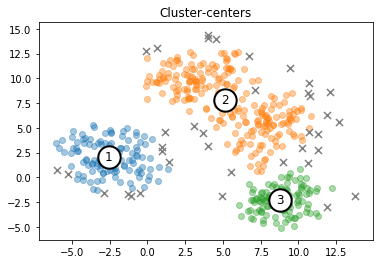

Noise : 37 (7%)


In [95]:
cluster_2D_plot(X[labels>-1], labels[labels>-1], core_points)
plt.scatter(X[labels==-1,0], X[labels==-1,1], s=50, 
            c='grey', alpha=1, marker='x')
plt.show()
noise = (labels==-1).sum()
print('Noise : {:,} ({:.0%})'.format(noise,noise/len(X)))